# Likelihood
### open source data quality monitor

Colin Jemmott
2020

Have you ever found out an ETL job failed because a customer called?  You ever retrain a machine learning model in production just to find out the data changed out from under you?  Have a dashboard break because new data violated your assumptions?

### Approach

Everything is probability (or, rather [surprise](https://en.wikipedia.org/wiki/Entropy_(information_theory)#Introduction)!).  Works on a two dataframes for now - you have to get the data.

Batch job, you pass in training and test.

Taxonomy of problems for initial launch:
- New values in categorical - bootstrapping
- Missing values - bootstrapping (Nan is just another category)
- Outliers in counts (missing or spike) - prophet

To Do:

- Outliers in counts of groups - bootstrapping
- Outliers in values - kernel density?

Later:
- Outliers in correlation between categories - assocation rules / Bayesian network / just conditional probability
- Delayed data (I think we need a writtenAt timestamp)
- Multi-table: check joins
- PCA?  Other anomaly detection?
- Multitenant

### Tips

Some of the analysis assumes that the data is stationary (ergodic).  If that is a bad assumption it might make sense to trim history.  maxTrainingSizeMultiple controls that.

### To Do

- Change out data for something public (SDPD?)
- Write params to JSON
- preprocessor on bootsrtapping for columns with tons of entries.  Also numerical columns?
- Throw a warning or error if the testing sample is too small?

In [1]:
import pandas as pd
import dateutil
from datetime import datetime, timedelta
import requests as rd
import numpy as np
import scipy.stats

# Get data

Not part of the actual product, but here for ease of testing.

In [2]:
import os
import pandas as pd
from datetime import datetime, timedelta


N_days = 90
batchHours = 7*24 # this grabs the most recent chunk and looks for differences with the remainder


# parameters (will put into JSON config file later)
params = {"fName": "pd_calls_for_service_2020_datasd.csv", # local CSV file only right now
          "ts": "date_time", # Timestamp for when the event happened in the world
          "bootstrapResamples":1000, # should probably be 10k for better accuracy, but much worse speed
          "maxTrainingSizeMultiple":10, # if there is more than X times more training data, trim to most recent
          "maxCategories":100, # maximum number of categories in a column - if higher we skip
          "minCategoryCount":10, # don't report boostrap surprise if a category has lower count
         }

## Load data, split into training and test

In [3]:
df = pd.read_csv("pd_calls_for_service_2020_datasd.csv")
if(df.shape[0] <= 30):
    print("Warning: not enough data")
df['ts'] = df[params['ts']]
print(df)
#.apply(dateutil.parser.parse, ignoretz=True) # could speed this up for ISO8601 - currently slow.
df['ts'] =  pd.to_datetime(df['ts'], format='%Y%m%d %H:%M:%S')
maxTs = max(df['ts'])
#df = df.assign(date_time = df.get("date_time").apply(datetime.strptime, args = ("%d/%m/%Y %H:%M:%S")))
batchTs = maxTs - timedelta(hours = batchHours)
testDf = df[df['ts'] > batchTs]
trainDf = df[df['ts'] < batchTs]

        incident_num            date_time  day_of_week  \
0       E20010000001  2020-01-01 00:00:09            4   
1       E20010000002  2020-01-01 00:00:20            4   
2       E20010000003  2020-01-01 00:00:21            4   
3       E20010000004  2020-01-01 00:00:32            4   
4       E20010000005  2020-01-01 00:00:42            4   
5       E20010000006  2020-01-01 00:01:04            4   
6       E20010000007  2020-01-01 00:01:11            4   
7       E20010000008  2020-01-01 00:01:15            4   
8       E20010000010  2020-01-01 00:01:33            4   
9       E20010000009  2020-01-01 00:01:33            4   
10      E20010000011  2020-01-01 00:02:22            4   
11      E20010000012  2020-01-01 00:02:45            4   
12      E20010000013  2020-01-01 00:03:25            4   
13      E20010000014  2020-01-01 00:03:53            4   
14      E20010000015  2020-01-01 00:03:53            4   
15      E20010000016  2020-01-01 00:03:54            4   
16      E20010

In [4]:
trainDf.keys()

Index(['incident_num', 'date_time', 'day_of_week', 'address_number_primary',
       'address_dir_primary', 'address_road_primary', 'address_sfx_primary',
       'address_dir_intersecting', 'address_road_intersecting',
       'address_sfx_intersecting', 'call_type', 'disposition', 'beat',
       'priority', 'ts'],
      dtype='object')

In [5]:
max(trainDf['ts'])

Timestamp('2020-04-07 23:49:55')

In [6]:
# Helpers and Math
def pValue(data, threshold):
    p_larger = sum(np.array(data) >= threshold) / len(data)
    p_smaller = sum(np.array(data) <= threshold) / len(data)
    p = min(p_larger, p_smaller)

    # only use gaussian p-value when there is variation, but bootsrap p = 0
    stdev = np.std(data)
    if stdev == 0 or p != 0:
        p_gauss = p
    else:
        p_gauss = scipy.stats.norm(np.mean(result['bootstrap_counts']), stdev).cdf(result['count'])
        p_gauss = min(p_gauss,1-p_gauss)
    return p_gauss

def trimTraining(trainDf, params):

    # trim to most recent
    trainDf = trainDf.sort_values(params['ts'], ascending =False)
    trainDfTrimmed = trainDf[:params['maxTrainingSizeMultiple']*len(testDf)]
    
    return trainDfTrimmed

In [7]:
# get all of the string columns
columnNames = []
for columnName in testDf.keys():
    if (type (testDf[columnName].iloc[0])) == str:
        columnNames.append(columnName)
print(columnNames)
bootstrapDf = trimTraining(trainDf, params)
        
# set up dict, add counts
results = {}
for columnName in columnNames:
    # if it isn't a string column, reject it
    if type(testDf[columnName].iloc[0]) != str:
        continue
    categories = (bootstrapDf[columnName].append(testDf[columnName])).unique()
    if len(categories) > params['maxCategories']:
        continue
    
    results[columnName] = {}
    testCounts = testDf[columnName].value_counts(dropna = False)
    for i in np.arange(1,len(categories) -1):
        if(pd.isna(categories[i])):
            categories = np.delete(categories, i)  
    for category in categories:
        results[columnName][category] = {'bootstrap_counts':[],
                                        'count':testCounts.get(category,0)}
# resample, add boostrap counts
for ii in range(params['bootstrapResamples']):
    # Draw random sample from training
    sampleDf = bootstrapDf.sample(len(testDf), replace=True)
    for columnName in results.keys():
        # count by category
        trainCounts = sampleDf[columnName].value_counts(dropna = False)
        # put results in dict
        for category in results[columnName].keys():
            boostrapCount = trainCounts.get(category,0)
            results[columnName][category]['bootstrap_counts'].append(boostrapCount)
              
# convert to records, add p-values
bootstrap_results = []
for columnName in results.keys():
    for category in results[columnName].keys():
        result = results[columnName][category]
        
        estimatedCount = int(np.round(np.mean(result['bootstrap_counts'])))
        # don't report entries with very low predicted and actual counts
        if estimatedCount < params['minCategoryCount'] and result['count'] < params['minCategoryCount']:
            continue
        
        p = pValue(result['bootstrap_counts'],result['count'])
        categoryName = category
        if not category:
            categoryName = "NULL"
        
        bootstrap_results.append({"column":columnName,
                           "category":categoryName,
                           "count":result['count'],
                           "p": p,
                           "estimated_count":estimatedCount,
                           })

resultsDf = pd.DataFrame.from_records(bootstrap_results).sort_values('p')
resultsDf['surprise'] = -np.log2(resultsDf['p'])

['incident_num', 'date_time', 'address_road_primary', 'address_sfx_primary', 'call_type', 'disposition']


/Users/gilpasternak/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log2


In [8]:
resultsDf.head(70)

,category,column,count,estimated_count,p,surprise
17,K,disposition,6425,5571,0.000000e+00,inf
23,CAN,disposition,638,879,8.239853e-18,56.752087
20,A,disposition,360,486,2.634361e-09,28.499900
21,R,disposition,723,878,1.331188e-08,26.162710
19,W,disposition,462,584,5.273638e-08,24.176626
18,O,disposition,1759,1955,8.453339e-07,20.173975
2,DR,address_sfx_primary,1242,1156,5.000000e-03,7.643856
15,LN,address_sfx_primary,68,87,1.800000e-02,5.795859
22,DUP,disposition,175,150,2.300000e-02,5.442222
25,X,disposition,18,27,2.900000e-02,5.107803


# Timeseries forecast (prophet)

Installing prophet is a major pain, especially on Windows.  Details: https://facebook.github.io/prophet/docs/installation.html

Following the lead from Seismic interns: https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473

Decided to go hourly, but could change to day with a few tweaks.

In [9]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [10]:
def truncateTs(ts):
    return ts.replace(minute=0, second=0,  microsecond=0)

In [11]:
truncatedData = trainDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetDf = pd.DataFrame({'ds':groupedCounts.index,'y':np.log10(groupedCounts.values)})
prophetDf

,ds,y
0,2020-01-01 00:00:00,2.184691
1,2020-04-06 09:00:00,2.143015
2,2020-02-20 09:00:00,2.136721
3,2020-04-03 14:00:00,2.133539
4,2020-01-16 09:00:00,2.130334
5,2020-03-02 09:00:00,2.120574
6,2020-02-24 08:00:00,2.113943
7,2020-01-16 08:00:00,2.110590
8,2020-02-12 08:00:00,2.110590
9,2020-03-11 09:00:00,2.107210


In [12]:
# find number of hours to preduct: ceil of hours in testDf
timeDelta = max(testDf['ts']) -min(testDf['ts'])
hours = int(timeDelta.days*24 + timeDelta.seconds/(60*60))+1
 
# Train model
m = Prophet(#daily_seasonality = True, 
            #yearly_seasonality = False, 
            #weekly_seasonality = True, 
            #growth='linear',
            interval_width=0.68 # one sigma
           )
m.add_country_holidays(country_name='US')

m.fit(prophetDf)

future = m.make_future_dataframe(periods = hours, freq = 'H')
fcst = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/gilpasternak/opt/miniconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [13]:
# group the test data
truncatedData = testDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetTestDf = pd.DataFrame({'ds':groupedCounts.index,
                              'y':np.log10(groupedCounts.values),
                              'y_linear':groupedCounts.values})

# find p-value
prophet_results = []

for ii in range(len(prophetTestDf)):
    ts = prophetTestDf['ds'][ii]
    fcstExample = fcst[fcst['ds'] == ts]
    mean = fcstExample['yhat'].iloc[0]
    stdev = (fcstExample['yhat_upper'].iloc[0] - fcstExample['yhat_lower'].iloc[0])/2
    p = scipy.stats.norm(mean, stdev).cdf(prophetTestDf['y'][ii])
    p = min(p,1-p)

    prophet_results.append({"column":"Forecast",
                       "category":str(ts),
                       "count":prophetTestDf['y_linear'][ii],
                       "p": p,
                       "estimated_count":int(np.round(np.power(10,mean))),
                       })
    
prophetResultsDf = pd.DataFrame.from_records(prophet_results).sort_values('p')
prophetResultsDf['surprise'] = -np.log2(prophetResultsDf['p'])
prophetResultsDf

,category,column,count,estimated_count,p,surprise
168,2020-04-07 23:00:00,Forecast,1,61,4.110487e-22,71.043109
158,2020-04-14 23:00:00,Forecast,22,61,8.131808e-03,6.942208
80,2020-04-14 06:00:00,Forecast,71,40,9.111577e-02,3.456155
143,2020-04-12 22:00:00,Forecast,33,59,9.633074e-02,3.375860
151,2020-04-08 01:00:00,Forecast,26,44,1.058663e-01,3.239685
127,2020-04-14 05:00:00,Forecast,46,27,1.099013e-01,3.185720
81,2020-04-13 06:00:00,Forecast,71,42,1.202267e-01,3.056171
167,2020-04-08 04:00:00,Forecast,16,26,1.256802e-01,2.992171
142,2020-04-08 00:00:00,Forecast,34,55,1.320363e-01,2.920994
136,2020-04-10 00:00:00,Forecast,35,57,1.332506e-01,2.907787


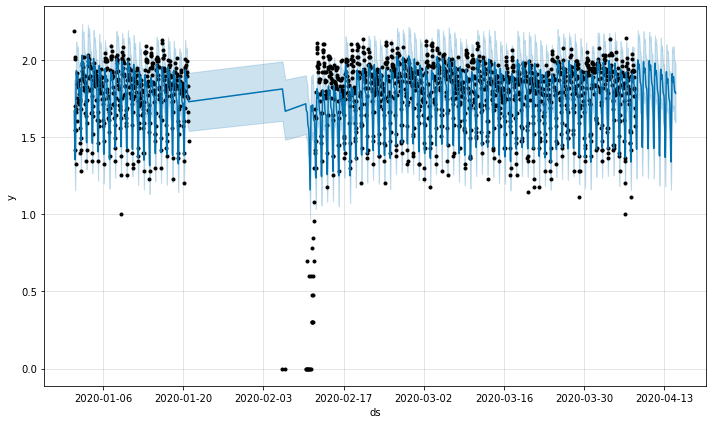

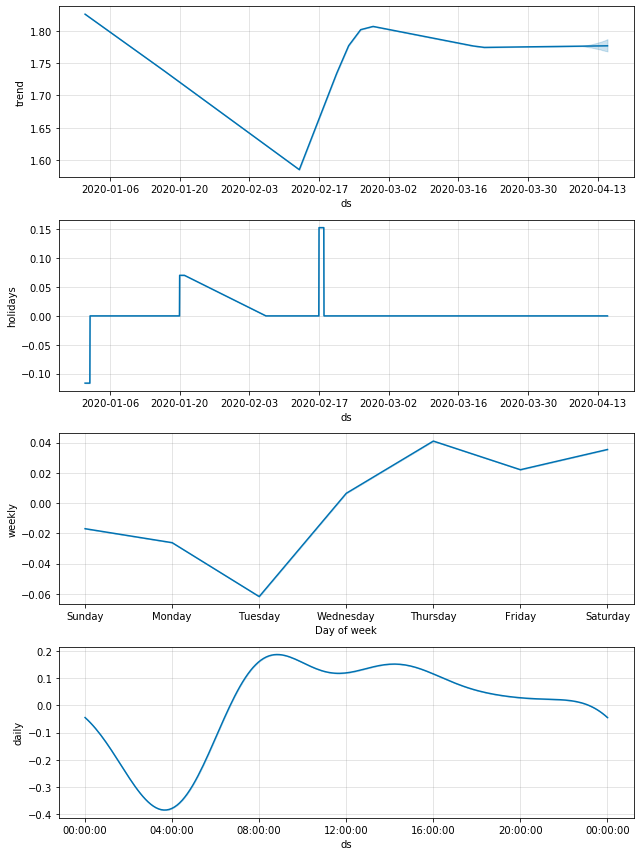

In [14]:
# plotting for debug only
fig = m.plot(fcst)
fig = m.plot_components(fcst)

In [30]:
prophetResultsDf.describe()

,count,estimated_count,p,surprise
count,169.00000,169.000000,1.690000e+02,169.000000
mean,64.04142,63.899408,3.388575e-01,2.051354
std,24.67777,20.637646,1.130642e-01,5.075866
min,1.00000,22.000000,6.446700e-21,1.007792
25%,46.00000,49.000000,2.631696e-01,1.185141
50%,70.00000,68.000000,3.441027e-01,1.539089
75%,80.00000,79.000000,4.397817e-01,1.925935
max,115.00000,100.000000,4.973066e-01,67.071929
